# Reference API for the nw2vec model

## Imports and setup

In [1]:
import time
import random
import os

import numpy as np
import scipy as sp
import scipy.stats
import sklearn.preprocessing
import matplotlib.pyplot as plt
import seaborn as sb
import networkx as nx

import keras
from keras import backend as K
import tensorflow as tf
from tensorflow.python import debug as tf_debug
from keras.utils.vis_utils import model_to_dot
from keras_tqdm import TQDMNotebookCallback as TQDMCallback

from progressbar import ProgressBar
from IPython.display import SVG, HTML, display

from nw2vec import ae
from nw2vec import utils
from nw2vec import codecs
from nw2vec import layers
from nw2vec import viz
from nw2vec import batching

Using TensorFlow backend.


In [2]:
random.seed(1)
np.random.seed(1)

## Drawing the predictions

In [3]:
def plot_ξ_distribution(glk, q_model, q_codecs, adj, features):
    assert len(q_codecs) == 1
    q_codec = q_codecs[0]
    
    g, l, k = glk
    palette = np.concatenate([np.array(sb.color_palette(n_colors=l)),
                              .5 * np.ones((l, 1))],
                             axis=1)
    communities = ([[i] for i in range(l)] * np.ones((l, k), dtype=np.int32)).reshape(-1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))#, sharex=True, sharey=True)

    q_pred = q_model.predict_fullbatch(adj=adj, features=features)

    # KDE plots
    q_pred_ξ_sample = K.eval(codecs.get_nocache(q_codec, q_pred).stochastic_value(100))
    for i in range(l):
        x = q_pred_ξ_sample[i * k:(i + 1) * k, :, 0].flatten()
        y = q_pred_ξ_sample[i * k:(i + 1) * k, :, 1].flatten()
        sb.kdeplot(x, y, cmap=sb.light_palette(palette[i], as_cmap=True),
                   shade=True, shade_lowest=False, ax=ax1)
    ax1.set_title(r'$\xi$ density for each community (flat nodes+sampling)')
    
    # μ plots
    q_pred_μ = q_pred[:, :2].T
    ax2.scatter(q_pred_μ[0], q_pred_μ[1], s=250, c=palette[communities])
    for i, (x, y) in enumerate(q_pred_μ.T):
        ax2.text(x, y, str(i), ha='center', va='center', color='white')
    ax2.set_title(r'$\mu = \left<\xi\right>$ for each node')
    
    # Box representing the μ plots in the KDE plots
    ax1.hlines(ax2.get_ylim(), *ax2.get_xlim(), colors='lightgrey')
    ax1.vlines(ax2.get_xlim(), *ax2.get_ylim(), colors='lightgrey')

In [4]:
def plot_predictions_sigmoidbernoullifeatures(model, adj, features):
    q_pred, adj_pred, v_pred = model.predict_fullbatch(adj=adj, features=features)
    adj_pred_mean = scipy.special.expit(adj_pred).mean(axis=1)[0]
    v_pred_mean = scipy.special.expit(v_pred).mean(axis=1)

    # Embeddings
    fig, ax = plt.subplots(figsize=(4, 4 * n_nodes / 25))
    im = ax.imshow(q_pred)
    ax.set_title('Embeddings')
    plt.colorbar(im, ax=ax)

    # Adjacency matrix
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

    im1 = ax1.imshow(nx.adjacency_matrix(g).toarray())
    ax1.set_title('Real adj')
    plt.colorbar(im1, ax=ax1)

    im2 = ax2.imshow(adj_pred_mean)
    im2.set_norm(im1.norm)
    ax2.set_title('Predicted adj')
    plt.colorbar(im2, ax=ax2)
    
    im3 = ax3.imshow(np.random.binomial(1, adj_pred_mean))
    im3.set_norm(im1.norm)
    ax3.set_title('Sampled predicted adj')
    plt.colorbar(im3, ax=ax3)

    # Features
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4 * n_nodes / 25))

    im1 = ax1.imshow(labels)
    ax1.set_title('Real labels')
    plt.colorbar(im1, ax=ax1)

    im2 = ax2.imshow(features)
    ax2.set_title('Features ( = noisy labels)')
    plt.colorbar(im2, ax=ax2)

    im3 = ax3.imshow(v_pred_mean)
    im3.set_norm(im1.norm)
    ax3.set_title('Predicted labels')
    plt.colorbar(im3, ax=ax3)
    
    im4 = ax4.imshow(np.random.binomial(1, v_pred_mean))
    im4.set_norm(im1.norm)
    ax4.set_title('Sampled predicted labels')
    plt.colorbar(im4, ax=ax4)

def plot_predictions_softmaxmultinomialfeatures(model, adj, labels, features):
    q_pred, adj_pred, v_pred = model.predict_fullbatch(adj=adj, features=features)
    adj_pred_mean = scipy.special.expit(adj_pred).mean(axis=1)[0]
    v_pred_mean = utils.softmax(v_pred).mean(axis=1)

    # Embeddings
    fig, ax = plt.subplots(figsize=(4, 4 * n_nodes / 25))
    im = ax.imshow(q_pred)
    ax.set_title('Embeddings')
    plt.colorbar(im, ax=ax)

    # Adjacency matrix
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

    im1 = ax1.imshow(nx.adjacency_matrix(g).toarray())
    ax1.set_title('Real adj')
    plt.colorbar(im1, ax=ax1)

    im2 = ax2.imshow(adj_pred_mean)
    im2.set_norm(im1.norm)
    ax2.set_title('Predicted adj')
    plt.colorbar(im2, ax=ax2)
    
    im3 = ax3.imshow(np.random.binomial(1, adj_pred_mean))
    im3.set_norm(im1.norm)
    ax3.set_title('Sampled predicted adj')
    plt.colorbar(im3, ax=ax3)

    # Features
    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(24, 4 * n_nodes / 25))

    im1 = ax1.imshow(labels)
    ax1.set_title('Real labels')
    plt.colorbar(im1, ax=ax1)

    im2 = ax2.imshow(utils.softmax(labels))
    im2.set_norm(im1.norm)
    ax2.set_title('Softmax labels (= features MN params)')
    plt.colorbar(im2, ax=ax2)
    
    im3 = ax3.imshow(features.sum(-1)[:, np.newaxis])
    ax3.set_title('Node MN draws')
    plt.colorbar(im3, ax=ax3)
    
    im4 = ax4.imshow(features)
    im4.set_norm(im3.norm)
    ax4.set_title('Features (multinomial)')
    plt.colorbar(im4, ax=ax4)

    im5 = ax5.imshow(v_pred_mean)
    im5.set_norm(im1.norm)
    ax5.set_title('Predicted feat. params')
    plt.colorbar(im5, ax=ax5)
    
    im6 = ax6.imshow(np.array([np.random.multinomial(n_samples_node, v_pred_mean_node)
                               for n_samples_node, v_pred_mean_node in zip(features.sum(-1), v_pred_mean)]))
    im6.set_norm(im3.norm)
    ax6.set_title('Sampled predicted features')
    plt.colorbar(im6, ax=ax6)

def plot_predictions_orthgaussianfeatures(model, g, adj, labels, features):
    n_nodes = adj.shape[0]
    q_pred, adj_pred, v_pred = model.predict_fullbatch(adj=adj, features=features)
    adj_pred_mean = scipy.special.expit(adj_pred).mean(axis=1)[0]
    v_pred_μ_mean = v_pred[:, :, :labels.shape[1]].mean(axis=1)
    v_pred_S_mean = np.exp(v_pred[:, :, labels.shape[1]:]).mean(axis=1)

    # Embeddings
    fig, ax = plt.subplots(figsize=(4, 4 * n_nodes / 25))
    im = ax.imshow(q_pred)
    ax.set_title('Embeddings')
    plt.colorbar(im, ax=ax)

    # Adjacency matrix
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

    im1 = ax1.imshow(nx.adjacency_matrix(g).toarray())
    ax1.set_title('Real adj')
    plt.colorbar(im1, ax=ax1)

    im2 = ax2.imshow(adj_pred_mean)
    im2.set_norm(im1.norm)
    ax2.set_title('Predicted adj')
    plt.colorbar(im2, ax=ax2)
    
    im3 = ax3.imshow(np.random.binomial(1, adj_pred_mean))
    im3.set_norm(im1.norm)
    ax3.set_title('Sampled predicted adj')
    plt.colorbar(im3, ax=ax3)

    # Features
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(16, 5 * n_nodes / 25))

    im1 = ax1.imshow(labels)
    ax1.set_title('Real labels')
    plt.colorbar(im1, ax=ax1)
    
    im2 = ax2.imshow(features)
    ax2.set_title('Features ( = noisy labels)')
    plt.colorbar(im2, ax=ax2)

    im3 = ax3.imshow(v_pred_μ_mean)
    im3.set_norm(im2.norm)
    ax3.set_title('Predicted features μ')
    plt.colorbar(im3, ax=ax3)
    
    im4 = ax4.imshow(v_pred_S_mean)
    #im4.set_norm(im1.norm)
    ax4.set_title('Predicted features S')
    plt.colorbar(im4, ax=ax4)
    
    im5 = ax5.imshow(np.random.normal(loc=v_pred_μ_mean, scale=v_pred_S_mean))
    im5.set_norm(im2.norm)
    ax5.set_title('Sampled predicted features')
    plt.colorbar(im5, ax=ax5)

## Test graph

/home/sl/.conda/envs/base36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


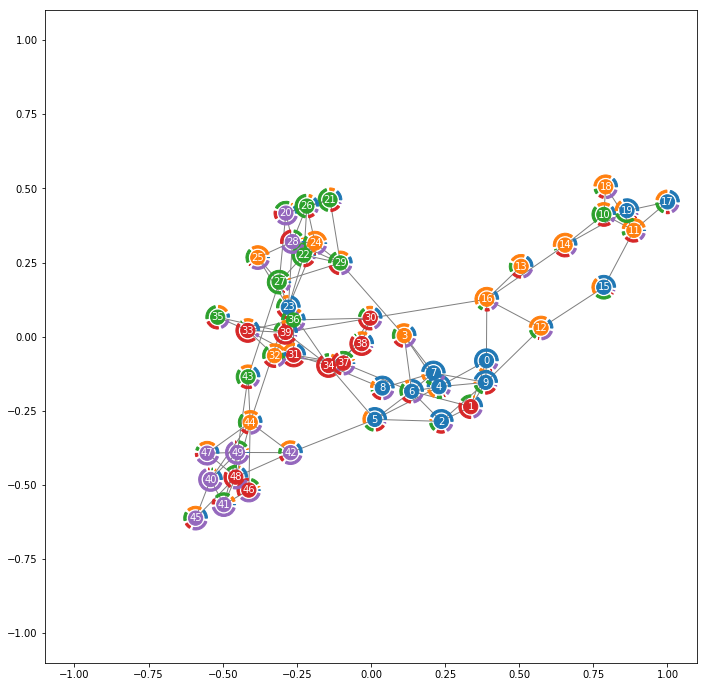

In [5]:
# Parameters
l = 5
k = 10
p_in = .4
p_out = .01
g = nx.planted_partition_graph(l, k, p_in, p_out)

# Show the graph
labels = np.zeros((l * k, l), dtype=np.float32)
for c in range(l):
    labels[range(c * k, (c + 1) * k), c] = 1

features = np.array([np.random.multinomial(np.random.randint(5, 20), utils.softmax(node_labels))
                     for node_labels in labels])
#features = labels + np.abs(np.random.normal(loc=0.0, scale=1.5, size=(l * k, l))).astype(np.float32)
viz.draw_network(g, labels=features);

## Build the VAE

In [6]:
# VAE Parameters
n_nodes = l * k
adj = nx.adjacency_matrix(g).astype(np.float32)

n_ξ_samples = 5
dim_data, dim_l1, dim_ξ_adj, dim_ξ_v = l, 10, 2, 2
overlap = 2
dims = (dim_data, dim_l1, dim_ξ_adj, dim_ξ_v)
loss_weights = {
    'q_mulogS_flat': 1e-2 * 1.0 / (dim_ξ_adj - overlap + dim_ξ_v),
    'p_adj': 1.0 / (n_nodes * np.log(2)),
    'p_v': 1.0 / (features.sum(-1).mean() * np.log(features.shape[1])),
}

# Actual VAE
q_model, q_codecs = ae.build_q(dims, overlap=overlap,
                               fullbatcher=batching.fullbatches, minibatcher=batching.pq_batches)
p_builder = ae.build_p_builder(dims,
                               feature_codec='SoftmaxMultinomial',
                               embedding_slices=[slice(dim_ξ_adj),
                                                 slice(dim_ξ_adj - overlap, dim_ξ_adj - overlap + dim_ξ_v)],
                               with_l1=True, share_l1=False)
vae, vae_codecs = ae.build_vae(
    (q_model, q_codecs), p_builder,
    n_ξ_samples,
    loss_weights=loss_weights
)

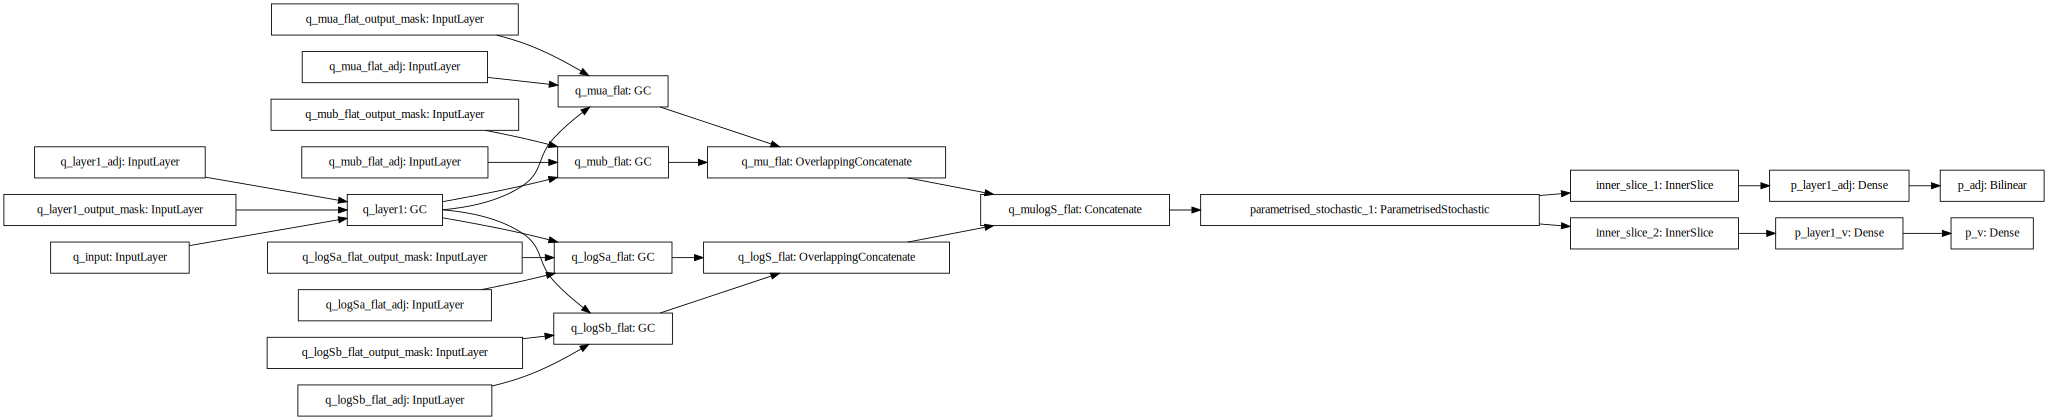

In [7]:
display(SVG(model_to_dot(vae, rankdir='LR').create(prog='dot', format='svg')))

## Before training

$\xi$ averages and distributions for each community, real and predicted adjacency matrices

/home/sl/.conda/envs/base36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


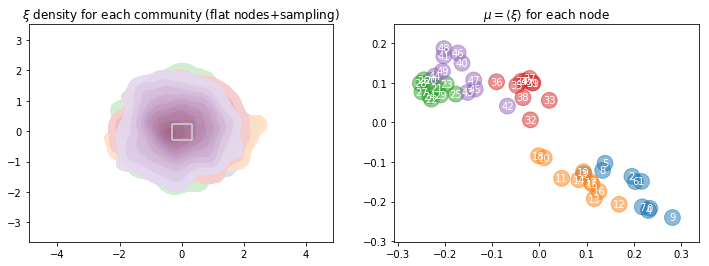

In [8]:
plot_ξ_distribution((g, l, k), q_model, q_codecs, adj, features)

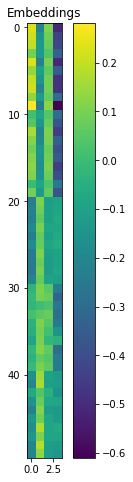

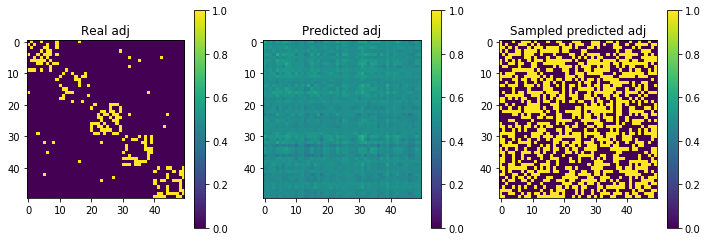

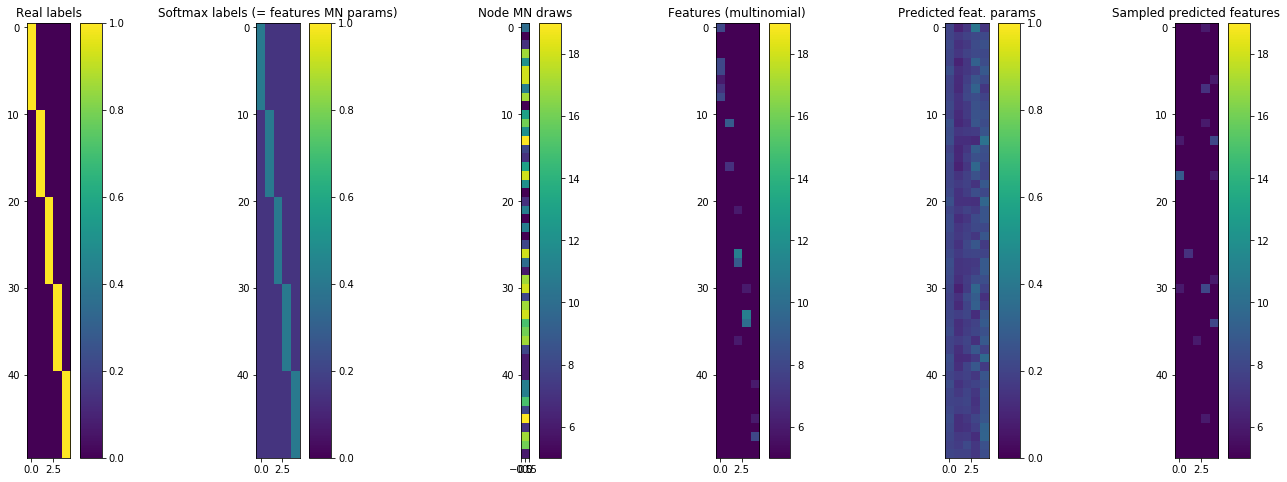

In [9]:
plot_predictions_softmaxmultinomialfeatures(vae, adj, labels, features)

## Train

In [10]:
n_epochs = 1000#5000

# Training targets
def target_func(batch_adj, required_nodes, final_nodes):
    return [
        np.zeros(1), # ignored
        utils.expand_dims_tile(utils.expand_dims_tile(batch_adj + np.eye(batch_adj.shape[0]), 0, n_ξ_samples), 0, 1),
        utils.expand_dims_tile(features[final_nodes], 1, n_ξ_samples),
    ]

### Fullbatch

In [11]:
history = vae.fit_fullbatches(batcher_kws={'adj': adj, 'features': features, 'target_func': target_func},
                              epochs=n_epochs,
                              verbose=0, callbacks=[TQDMCallback(show_inner=False)])

/home/sl/.conda/envs/base36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/sl/.conda/envs/base36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/sl/.conda/envs/base36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/sl/.conda/envs/base36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserW

Usually, the cell above complains with "UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.". See these for more details:
* https://stackoverflow.com/questions/35892412/tensorflow-dense-gradient-explanation#35896823
* https://stackoverflow.com/questions/39111373/tensorflow-chaining-tf-gather-produces-indexedslices-warning

### Minibatch

In [12]:
#seeds_per_batch = int(np.ceil(n_nodes / 10))
#max_walk_length = 5
#p, q = 1, 1
#neighbour_samples = None
#steps_per_epoch = int(np.ceil(n_nodes / seeds_per_batch))

In [13]:
#history = vae.fit_minibatches(batcher_kws={'adj': adj, 'features': features, 'target_func': target_func,
#                                           'seeds_per_batch': seeds_per_batch,
#                                           'max_walk_length': max_walk_length,
#                                           'p': q, 'q': q,
#                                           'neighbour_samples': neighbour_samples},
#                                 steps_per_epoch=steps_per_epoch,
#                                 epochs=n_epochs,
#                                 verbose=0, callbacks=[TQDMCallback(show_inner=False)])

Usually, the cell above complains with "UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.". See these for more details:
* https://stackoverflow.com/questions/35892412/tensorflow-dense-gradient-explanation#35896823
* https://stackoverflow.com/questions/39111373/tensorflow-chaining-tf-gather-produces-indexedslices-warning

## Training results

initial scaled loss = 2.3836395740509033
initial scaled q_mulogS_flat_loss = 0.0004755058139562607
initial scaled p_adj_loss = 1.1065096289094485
initial scaled p_v_loss = 1.0538936112631472


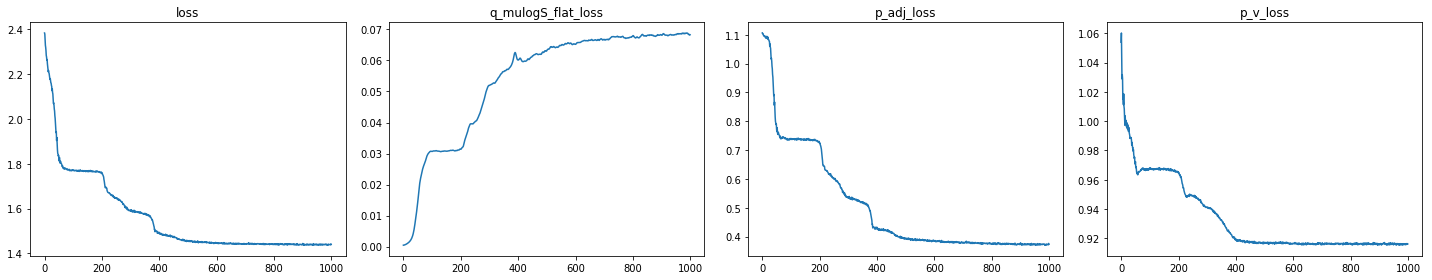

In [14]:
fig, axes = plt.subplots(1, len(history.history), figsize=(len(history.history) * 5, 4))
for i, (title, values) in enumerate(history.history.items()):
    scaled_values = np.array(values) * loss_weights.get(title[:-5], 1)
    print('initial scaled {} ='.format(title), scaled_values[0])
    axes[i].plot(scaled_values)
    axes[i].set_title(title)
fig.tight_layout()

In [15]:
(loss_weights['p_adj'] * np.array(history.history['p_adj_loss']))[-200:].mean()

0.37349235997472474

In [16]:
(loss_weights['p_v'] * np.array(history.history['p_v_loss']))[-200:].mean()

0.9162103292300782

$\xi$ averages and distributions for each community, real and predicted adjacency matrices

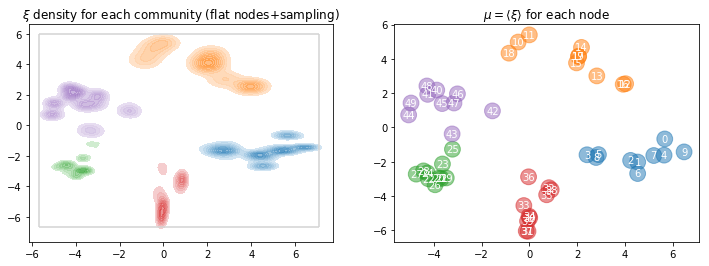

In [17]:
plot_ξ_distribution((g, l, k), q_model, q_codecs, adj, features)

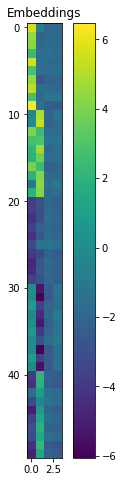

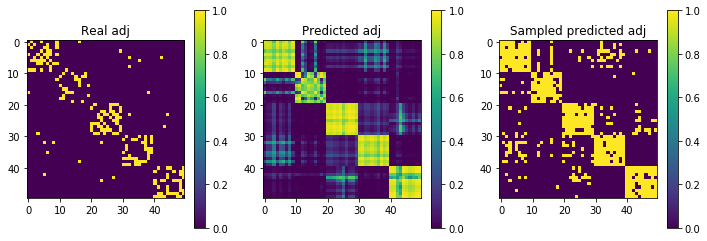

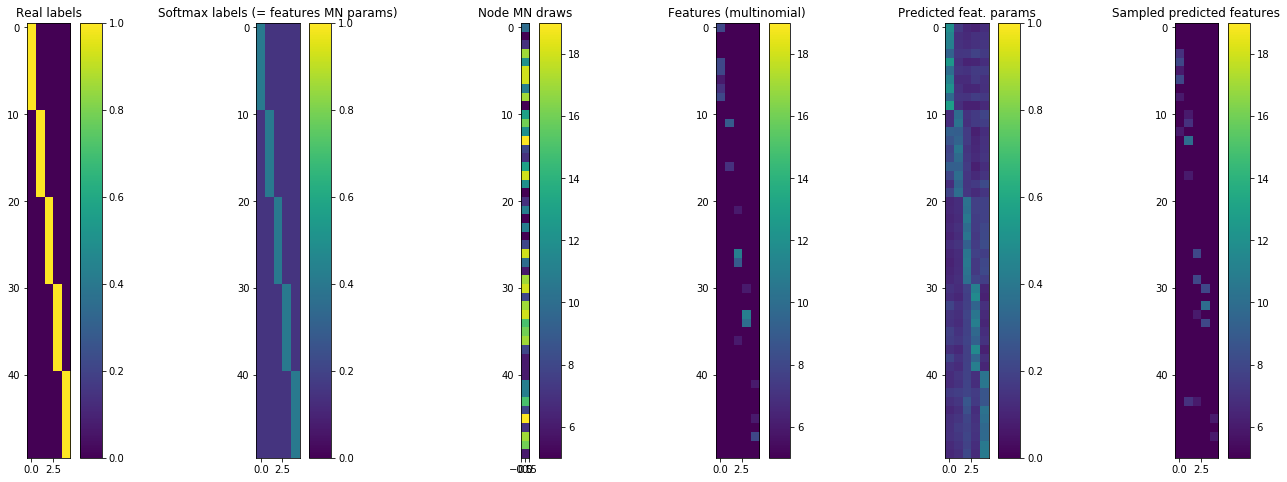

In [18]:
plot_predictions_softmaxmultinomialfeatures(vae, adj, labels, features)

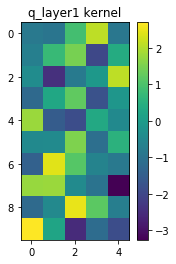

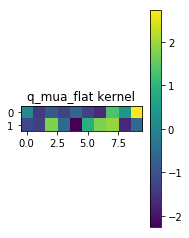

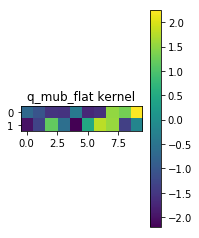

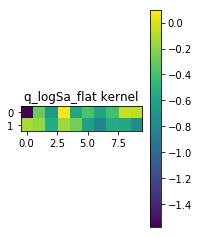

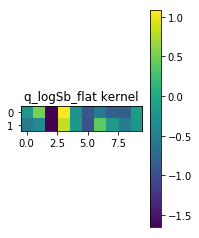

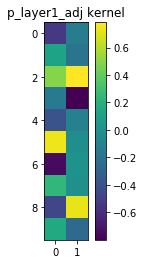

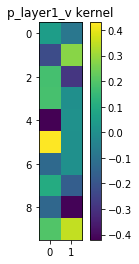

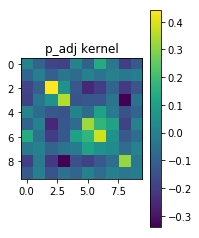

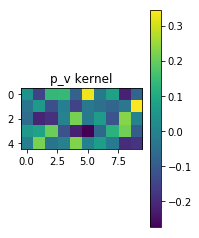

In [19]:
for layer in vae.layers:
    if hasattr(layer, 'kernel'):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))#, sharey=True)
        im1 = ax1.imshow(K.eval(layer.kernel).T)
        ax1.set_title('{} kernel'.format(layer.name))
        plt.colorbar(im1, ax=ax1)
        if hasattr(layer, 'bias') and layer.bias is not None:
            im2 = ax2.imshow(K.eval(K.expand_dims(layer.bias, -1)))
            ax2.set_title('{} bias'.format(layer.name))
            plt.colorbar(im2, ax=ax2)
        else:
            ax2.set_visible(False)